# Tutorial: Photovoltaics problem setup

This tutorial demonstrates optimization of a photovoltaics antireflective coating. Note that the aim is not to reproduce the exact results from the paper, but to demonstrate how to setup the problem.

In [6]:
# install dependecies
!pip install -U pymoosh
!pip install -U nevergrad

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


## Load modules

In [7]:
import nevergrad as ng
import matplotlib.pyplot as plt
import PyMoosh as pm
import numpy as np

## Helper: define the optimization geometry

Here we define the geometric model to be optimized and its parametrization. We will optimize the thicknesses of a layer-stack of two alterning dielectric materials with fixed permittivity (2 and 3). These layer-pairs are on a thick a-Silicon layer, that represents the active layer of a solar cell.

The thickness of the aSi layer will be provided as keyword arguments, so we can later set it artificially smaller, for plotting of the layer stack.

In [8]:
def setup_structure(x, thick_aSi=30000):
    """helper to create pymoosh structure object, alternating 2 materials

    the substrate is amorphous silicon and the light is incident through air (n=1).
    The structure is made of alternating layers of eps=2 and eps=3.

    Args:
        X (list): long list of thicknesses

    Returns:
        PyMoosh.structure: multi-layer structure object
    """
    x = list(x)  # convert to list for convenience when stacking layers
    n_layers = len(x)

    # available materials (alternating eps=2 and eps=3)
    materials = [1., 2., 3., "SiA"]
    # material sequence of layer-stack
    stack = [0] + [1,2] * (n_layers//2) + [3]
    # thicknesses of layers
    thicknesses = [0] + x + [thick_aSi]

    structure = pm.Structure(
        materials, stack, np.array(thicknesses), verbose=False)

    return structure

## Helper: define the optimization target

Now we define the *cost* function. We want to maximize $\eta_{solar}$, the solar cell efficiency.
By default Nevergrad algorithms minimize the cost. In order to maximize the target physical propery we use $f_{cost} = 1-\eta_{solar}$.

Essentially, we will maximize the spectrally integrated absorption in the solar cell active layer (amorphous silicon), weighted by the solar spectrum.

In [9]:
# ------- the optimization target function -------
def cost_photo(x, wl_min, wl_max, number_pts=50, pola=0, incidence=0):
    """ cost function: (negative) efficiency of solar cell

    Args:
        x (list): materials (first half) & thicknesses (second half) of all layers
        wl_min, wl_max (float): spectral limits of efficiency evaluation

    Returns:
        float: 1 - Reflectivity at target wavelength
    """
    structure = setup_structure(x)

    # the actual PyMoosh reflectivity simulation
    active_lay = len(x)+1

    eff, _, _, _, _, _ = pm.photo(
        structure, incidence, pola, wl_min, wl_max, active_lay, number_pts)
    cost = 1 - eff

    return cost


## Setting up the optimization problem

Now we define the specific configuration of our optimization problem. For photovoltaics we want to optimize a sequence of alternating layers of fixed material ($\epsilon=2, \epsilon=3$) as an antireflection coating.

Finally we set up the parametrization for nevergrad and configure the optimizer.

In [13]:
# ------- define "photovoltaic" optimization problem
nb_layers = 10
min_thick = 30     # nm
max_thick = 250
wl_min = 375.0     # nm
wl_max = 750.0


# ------- setup the parametrization
budget = 10000    # stop criterion: allowed number of evaluations
N_population = 30 # population size

# parametrization
# bounds for free params: layer permittivities and thicknesses
init = [min_thick + (max_thick-min_thick) * np.random.rand() for _ in range(nb_layers)]
args_mat_thick_ng = ng.p.Array(
    init=init,
    lower=[min_thick]*nb_layers,
    upper=[max_thick]*nb_layers,
)

# wrap free and fixed arguments
instrumentation = ng.p.Instrumentation(
    # --- optimization args
    x=args_mat_thick_ng,

    # --- additional, fixed args
    wl_min=wl_min,
    wl_max=wl_max,
)


# ------- setup the optimizer
# configure specific variant from DE optimizer family
optim_algos_DE = ng.families.DifferentialEvolution(
    crossover="twopoints", popsize=N_population)

# initialize the optimizer
optimizer = optim_algos_DE(instrumentation, budget=budget)
optimizer.register_callback("tell", ng.callbacks.ProgressBar())

## Run the optimization

Pass the cost function (`cost_photo`) to the `minimize` function of the optimizer.

In [14]:
x_opt = optimizer.minimize(cost_photo)

100%|██████████| 10000/10000 [05:28<00:00, 30.47it/s]

100%|██████████| 10000/10000 [05:40<00:00, 30.47it/s]

## Analyze the result

Finally, we calculate the spectrum for the best solution and plot the results:

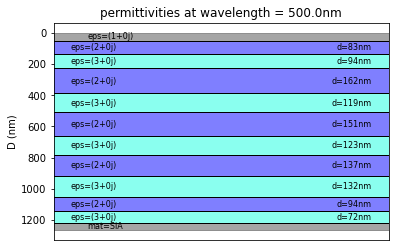

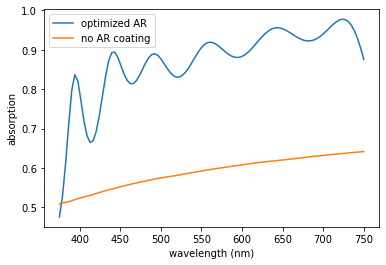

In [12]:
x = x_opt.value[1]['x']
struct_opt = setup_structure(x)

# calculate abs. spectrum
_, _, _, wl, _, spec_A = pm.photo(
    struct_opt, incidence=0, polarization=0,
    wl_min=wl_min, wl_max=wl_max,
    active_layers=len(x)+1, number_points=100)


# calculate abs. spectrum of bare aSi (all thicknesses zero)
struct_zeros = setup_structure(np.zeros_like(x))
_, _, _, wl, _, spec_A_zero = pm.photo(
    struct_zeros, incidence=0, polarization=0,
    wl_min=wl_min, wl_max=wl_max,
    active_layers=len(x)+1, number_points=100)


# plot
plt.figure()
plt.subplot(title='optimized structure')
struct_opt_for_plot = setup_structure(x, thick_aSi=0)
struct_opt_for_plot.plot_stack()

plt.figure()
plt.plot(wl, spec_A, color='C0', label='optimized AR')
plt.plot(wl, spec_A_zero, color='C1', label='no AR coating')
plt.legend()
plt.xlabel('wavelength (nm)')
plt.ylabel('absorption')
plt.show()